In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import cv2 as cv

In [2]:
# ACTIONS
MOVE_RIGHT         = 0
MOVE_DOWN          = 1
SCALE_UP           = 2
ASPECT_RATIO_UP    = 3
MOVE_LEFT          = 4
MOVE_UP            = 5
SCALE_DOWN         = 6
ASPECT_RATIO_DOWN  = 7
SPLIT_HORIZONTAL   = 8
SPLIT_VERTICAL     = 9
PLACE_LANDMARK     = 10
SKIP_REGION        = 11



DIMENSION = 224
STEP_FACTOR = 0.2
MAX_ASPECT_RATIO = 6.00
MIN_ASPECT_RATIO = 0.15
MIN_BOX_SIDE     = 10

class ObjLocaliser(object):
        
    def __init__(self, image, boundingBoxes):
        
        #Loading image using PIL librarry to resize it to standard dimention which is acceptable by the network
        #PILimg = Image.fromarray(image)
        PILimg = image
        #Resizing the image to be compatible to the network
        #resized_img = PILimg.resize((DIMENSION,DIMENSION))
        resized_img = cv.resize(PILimg,(DIMENSION,DIMENSION))
        #Image is stored as np array
        self.image_playground = np.array(resized_img)
        print image.shape
        self.yscale = float(DIMENSION)/image.shape[0]
        self.xscale = float(DIMENSION)/image.shape[1]
        self.targets = self.gettingTargerReady(boundingBoxes)
        
        #Initializing sliding window from top left corner of the image
        #self.agent_window = np.array([0,0,DIMENSION,DIMENSION])
        self.agent_window = np.array([0,0,DIMENSION,DIMENSION])
        self.iou = 0
        #fig,ax = plt.subplots(1)
        #self.myplot = [fig,ax]
        #plt.show()

        
        self.actoins = {
            0: 'MOVE_RIGHT',
            1: 'MOVE_DOWN',
            2: 'SCALE_UP',
            3: 'ASPECT_RATIO_UP',
            4: 'MOVE_LEFT',
            5: 'MOVE_UP',
            6: 'SCALE_DOWN',
            7: 'ASPECT_RATIO_DOWN',
            8: 'SPLIT_HORIZONTAL',
            9: 'SPLIT_VERTICAL',
            10: 'PLACE_LANDMARK',
            11: 'SKIP_REGION'
        }
        
        
        
    def gettingTargerReady(self, boundingBoxes):
        numOfObj = len(boundingBoxes['xmax'])
        objs = []
        for i in range(numOfObj):
            temp = [boundingBoxes['xmin'][i]*self.xscale, boundingBoxes['ymin'][i]*self.yscale, boundingBoxes['xmax'][i]*self.xscale, boundingBoxes['ymax'][i]*self.yscale]
            objs.append(temp)
        return objs
        
    def wrapping(self):
        
        #Pick selected window from image
        im2 = self.image_playground[self.agent_window[1]:self.agent_window[3],self.agent_window[0]:self.agent_window[2]]
        #Resizing the agent window to be compatible for network input
        #resized = Image.fromarray(im2).resize((DIMENSION,DIMENSION))
        resized = cv.resize(im2,(DIMENSION,DIMENSION))
        resized = np.stack((resized[:,:,0],resized[:,:,1],resized[:,:,2],self.image_playground[:,:,0],self.image_playground[:,:,1],self.image_playground[:,:,2]), axis=2)
        return resized
    
    
    def takingActions(self,action):

        newbox = np.array([0,0,0,0])
        termination = False
        if action == MOVE_RIGHT:           
            newbox = self.MoveRight()
        elif action == MOVE_DOWN:         
            newbox = self.MoveDown()
        elif action == SCALE_UP:           
            newbox = self.scaleUp()
        elif action == ASPECT_RATIO_UP:    
            newbox = self.aspectRatioUp()
        elif action == MOVE_LEFT:       
            newbox = self.MoveLeft()
        elif action == MOVE_UP:       
            newbox = self.MoveUp()
        elif action == SCALE_DOWN:         
            newbox = self.scaleDown()
        elif action == ASPECT_RATIO_DOWN:  
            newbox = self.aspectRatioDown()
        elif action == SPLIT_HORIZONTAL:   
            newbox = self.splitHorizontal()
        elif action == SPLIT_VERTICAL:     
            newbox = self.splitVertical()
        elif action == PLACE_LANDMARK:
            newbox = self.placeLandmark()
            termination = True
        #elif action == SKIP_REGION:        
            #self.skipRegion()

        self.agent_window = newbox
        self.adjustAndClip()
        r = self.ComputingReward(termination)
            
        return r
        
     


    def MoveRight(self):
        
        newbox = self.agent_window 
        boxW = self.agent_window[2] - self.agent_window[0]
        step = STEP_FACTOR * boxW
        # This action preserves box width and height
        if self.agent_window[2] + step < self.image_playground.shape[0]:
            newbox[0] += step
            newbox[2] += step
        else:
            newbox[0] = self.image_playground.shape[0] - boxW - 1
            newbox[2] = self.image_playground.shape[0] - 1 
            
        return newbox
            
            

    def MoveDown(self):
        
        newbox = self.agent_window 
        boxH = self.agent_window[3] - self.agent_window[1]
        step = STEP_FACTOR * boxH
        # This action preserves box width and height
        if self.agent_window[3] + step < self.image_playground.shape[1]:
            newbox[1] += step
            newbox[3] += step
        else:
            newbox[1] = self.image_playground.shape[1] - boxH - 1
            newbox[3] = self.image_playground.shape[1] - 1
            
        return newbox
        
        
        
        
        
    def scaleUp(self):
        
        newbox = self.agent_window 
        boxW = self.agent_window[2] - self.agent_window[0]
        boxH = self.agent_window[3] - self.agent_window[1]
        
        # This action preserves aspect ratio
        widthChange = STEP_FACTOR * boxW
        heightChange = STEP_FACTOR * boxH
        
        if boxW + widthChange < self.image_playground.shape[0]:
            if boxH + heightChange < self.image_playground.shape[1]:
                newDelta = STEP_FACTOR
            else:
                newDelta = self.image_playground.shape[1] / boxH - 1
        else:
            newDelta = self.image_playground.shape[0] / boxW - 1
            if boxH + (newDelta * boxH) >= self.image_playground.shape[1]:
                newDelta = self.image_playground.shape[1] / boxH - 1
        
        widthChange = newDelta * boxW / 2.0
        heightChange = newDelta * boxH / 2.0
        newbox[0] -= widthChange
        newbox[1] -= heightChange
        newbox[2] += widthChange
        newbox[3] += heightChange
        
        return newbox

        
        

    def aspectRatioUp(self):
        
        newbox = self.agent_window
        boxH = self.agent_window[3] - self.agent_window[1]
        boxW = self.agent_window[2] - self.agent_window[0]
        
        # This action preserves width
        heightChange = STEP_FACTOR * boxH
        
        if boxH + heightChange < self.image_playground.shape[1]:
            ar = (boxH + heightChange) / boxW
            if ar < MAX_ASPECT_RATIO:
                newDelta = STEP_FACTOR
            else:
                newDelta = 0.0
        else:
            newDelta = self.image_playground.shape[1] / boxH - 1
            ar = (boxH + newDelta * boxH) / boxW
            if ar > MAX_ASPECT_RATIO:
                newDelta =  0.0
                
        heightChange = newDelta * boxH / 2.0
        newbox[1] -= heightChange
        newbox[3] += heightChange
        
        return newbox

        
        
    def MoveLeft(self):
        
        newbox = self.agent_window
        boxW = self.agent_window[2] - self.agent_window[0]
        step = STEP_FACTOR * boxW
        
        # This action preserves box width and height
        if self.agent_window[0] - step >= 0:
            newbox[0] -= step
            newbox[2] -= step
        else:
            newbox[0] = 0
            newbox[2] = boxW
        
        return newbox


    def MoveUp(self):

        newbox = self.agent_window
        
        boxH = self.agent_window[3] - self.agent_window[1]
        
        step = STEP_FACTOR * boxH
        # This action preserves box width and height
        if self.agent_window[1] - step >= 0:
            newbox[1] -= step
            newbox[3] -= step
        else:
            newbox[1] = 0
            newbox[3] = boxH

        return newbox
            

    def scaleDown(self):
        
        newbox = self.agent_window
        
        boxH = self.agent_window[3] - self.agent_window[1]
        boxW = self.agent_window[2] - self.agent_window[0]
        
        
        # This action preserves aspect ratio
        widthChange = STEP_FACTOR * boxW
        heightChange = STEP_FACTOR * boxH
        
        if boxW - widthChange >= MIN_BOX_SIDE:
            if boxH - heightChange >= MIN_BOX_SIDE:
                newDelta = STEP_FACTOR
            else:
                newDelta = MIN_BOX_SIDE / boxH - 1
        else:
            newDelta = MIN_BOX_SIDE / boxW - 1
            if  boxH - newDelta *  boxH < MIN_BOX_SIDE:
                newDelta = MIN_BOX_SIDE /  boxH - 1
        widthChange = newDelta * boxW / 2.0
        heightChange = newDelta * boxH / 2.0

        newbox[0] += widthChange
        newbox[1] += heightChange
        newbox[2] -= widthChange
        newbox[3] -= heightChange

        return newbox

        
        
    def splitHorizontal(self):
        
        newbox = self.agent_window
        boxW = self.agent_window[2] - self.agent_window[0]
        if boxW >  MIN_BOX_SIDE:
            half = boxW / 2.0
            newbox[2] -= half
        return newbox

    
    def splitVertical(self): 
        
        newbox = self.agent_window
        boxH = self.agent_window[3] - self.agent_window[1]
        if boxH > MIN_BOX_SIDE:
            half = boxH/2.0
            newbox[3] -= half
        return newbox
        
        
    def aspectRatioDown(self):

        newbox = self.agent_window
        
        boxW = self.agent_window[2] - self.agent_window[0]
        boxH = self.agent_window[3] - self.agent_window[1]

        # This action preserves height
        widthChange = STEP_FACTOR * boxW
        if boxW + widthChange < self.image_playground.shape[0]:
            ar = boxH / (boxW + widthChange)
            if ar >= MIN_ASPECT_RATIO:
                newDelta = STEP_FACTOR
            else:
                newDelta = 0.0
        else:
            newDelta = self.image_playground.shape[0] / boxW - 1
            ar = boxH / (boxW + newDelta * boxW)
            if ar < MIN_ASPECT_RATIO:
                newDelta =  0.0
        widthChange = newDelta * boxW / 2.0
        newbox[0] -= widthChange
        newbox[2] += widthChange
        
        return newbox
         
    def placeLandmark(self):
        
        newbox = self.agent_window
        
        h = (self.agent_window[3] - self.agent_window[1])/2
        h_l = h/5
        w = (self.agent_window[2] - self.agent_window[0])/2
        w_l = w/5
        
        self.image_playground[self.agent_window[1]+h-h_l:self.agent_window[1]+h+h_l,self.agent_window[0]:self.agent_window[2]] = 0
        self.image_playground[self.agent_window[1]:self.agent_window[3],self.agent_window[0]+w-w_l:self.agent_window[0]+w+w_l] = 0
                
        return newbox

        
        
        
        
    def adjustAndClip(self):
        
        #Cheching if x coordinate of the top left corner is out of bound    
        if self.agent_window[0] < 0:
            step = -self.agent_window[0]
            if self.agent_window[2] + step < self.image_playground.shape[0]:
                self.agent_window[0] += step
                self.agent_window[2] += step
            else:
                self.agent_window[0] = 0
                self.agent_window[2] = self.image_playground.shape[0] - 1

        #Cheching if y coordinate of the top left corner is out of bound    
        if self.agent_window[1] < 0:
            step = -self.agent_window[1]
            if self.agent_window[3] + step < self.image_playground.shape[1]:
                self.agent_window[1] += step
                self.agent_window[3] += step
            else:
                self.agent_window[1] = 0
                self.agent_window[3] = self.image_playground.shape[1] - 1

        #Cheching if x coordinate of the bottom right corner is out of bound    
        if self.agent_window[2] >= self.image_playground.shape[0]:
            step = self.agent_window[2] - self.image_playground.shape[0]
            if self.agent_window[0] - step >= 0:
                self.agent_window[0] -= step
                self.agent_window[2] -= step
            else:
                self.agent_window[0] = 0
                self.agent_window[2] = self.image_playground.shape[0] - 1

        #Cheching if y coordinate of the bottom right corner is out of bound    
        if self.agent_window[3] >= self.image_playground.shape[1]:
            step = self.agent_window[3] - self.image_playground.shape[1]
            if self.agent_window[1] - step >= 0:
                self.agent_window[1] -= step
                self.agent_window[3] -= step
            else:
                self.agent_window[1] = 0
                self.agent_window[3] = self.image_playground.shape[1] - 1
                
        if self.agent_window[0] == self.agent_window[2]:
            if self.agent_window[2] + MIN_BOX_SIDE < self.image_playground.shape[0]:
                self.agent_window[2] = self.agent_window[2] + MIN_BOX_SIDE
            else:
                self.agent_window[0] = self.agent_window[0] - MIN_BOX_SIDE
                
        if self.agent_window[1] == self.agent_window[3]:
            if self.agent_window[3] + MIN_BOX_SIDE < self.image_playground.shape[1]:
                self.agent_window[3] = self.agent_window[3] + MIN_BOX_SIDE
            else:
                self.agent_window[1] = self.agent_window[1] - MIN_BOX_SIDE

                
    def intersectionOverUnion(self, boxA, boxB):
        
        # determine the (x, y)-coordinates of the intersection rectangle
        #boxA = self.agent_window
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])

        # compute the area of intersection rectangle
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)

        # return the intersection over union value
        return iou  
    
    
    def ComputingReward(self, termination = False):
        
        new_iou = self.intersectionOverUnion(self.agent_window, np.array(self.targets[0]))
        reward = 0
        
        if new_iou - self.iou > 0:
            reward = 1
        else:
            reward = -1
            
        if termination:
                        
            if (new_iou > 0.6) or (new_iou == 1):
                reward = 3
            else:
                reward = -3
            
        self.iou = new_iou
        return reward
                        
        
        
    def drawActions(self):
                
        # Create figure and axes
        fig,ax = plt.subplots(1)

        # Display the image
        ax.imshow(self.image_playground)

        # Create a Rectangle patch
        rect = patches.Rectangle((self.agent_window[0],self.agent_window[1]),self.agent_window[2]-self.agent_window[0],self.agent_window[3]-self.agent_window[1],linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.draw()
        plt.show()

        

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline
import matplotlib.patches as patches
import time

actn = {
    0: 'MOVE_RIGHT',
    1: 'MOVE_DOWN',
    2: 'SCALE_UP',
    3: 'ASPECT_RATIO_UP',
    4: 'MOVE_LEFT',
    5: 'MOVE_UP',
    6: 'SCALE_DOWN',
    7: 'ASPECT_RATIO_DOWN',
    8: 'SPLIT_HORIZONTAL',
    9: 'SPLIT_VERTICAL',
    10: 'PLACE_LANDMARK',
    11: 'SKIP_REGION'
    
}


# ACTIONS
MOVE_RIGHT         = 0
MOVE_DOWN          = 1
SCALE_UP           = 2
ASPECT_RATIO_UP    = 3
MOVE_LEFT          = 4
MOVE_UP            = 5
SCALE_DOWN         = 6
ASPECT_RATIO_DOWN  = 7
SPLIT_HORIZONTAL   = 8
SPLIT_VERTICAL     = 9
SKIP_REGION        = 11
PLACE_LANDMARK     = 10


im2 = (Image.open('../VOC2012/JPEGImages/2010_000959.jpg'))
#im2 = (Image.open('../VOC2012/JPEGImages/2009_002749.jpg'))



1


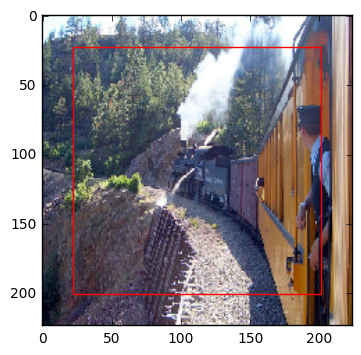

-1


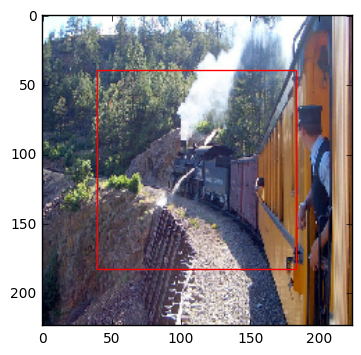

-1


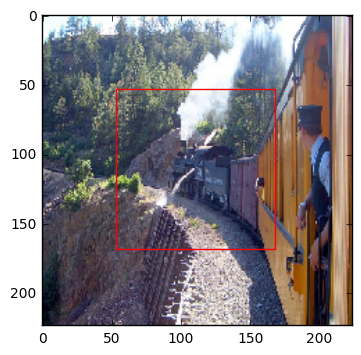

1


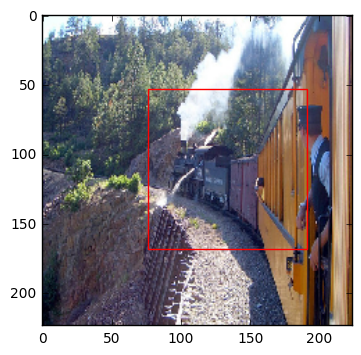

1


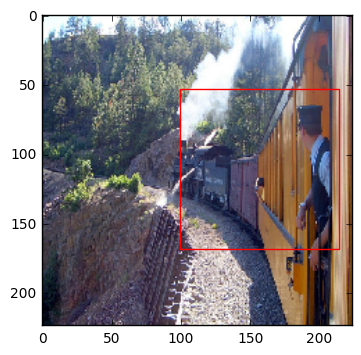

1


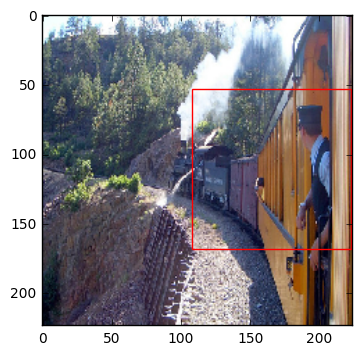

-1


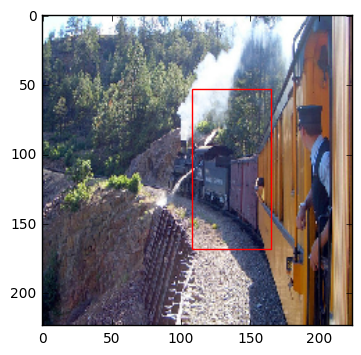

1


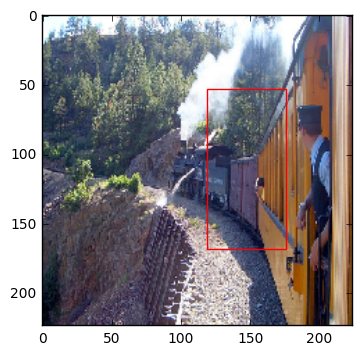

1


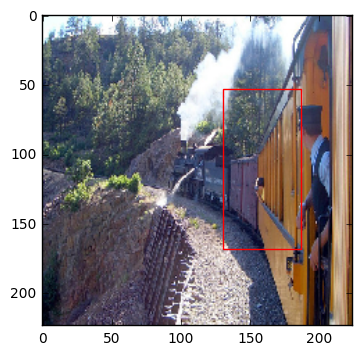

1


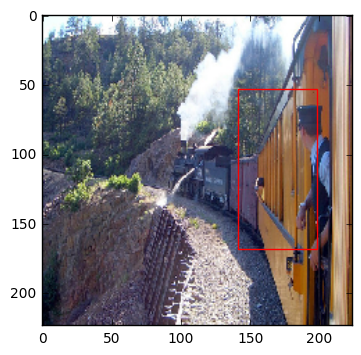

1


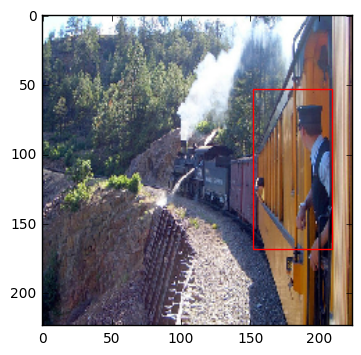

1


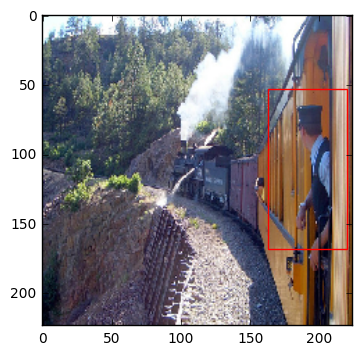

3


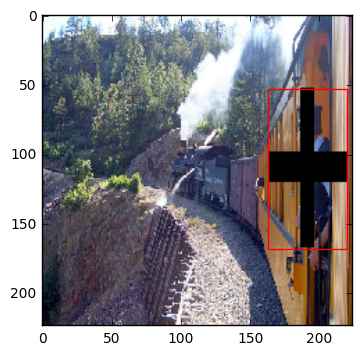

In [33]:
agent = ObjLocaliser(im2,{'xmin':[170], 'xmax':[220], 'ymin':[58], 'ymax':[206]})
#agent.agent_window = np.array([170,20,220,206])
#print agent.targets
for i in [6,6,6,0,0,0,8,0,0,0,0,0,10]:
    print agent.takingActions(i)
    agent.drawActions()

In [20]:
agent = ObjLocaliser(im2,{'xmin':[170], 'xmax':[220], 'ymin':[58], 'ymax':[206]})
agent.agent_window = [170,220,58,206]
agent.intersectionOverUnion([90,200,58,206],[170,220,58,206])

0.0

(500, 224, 3)


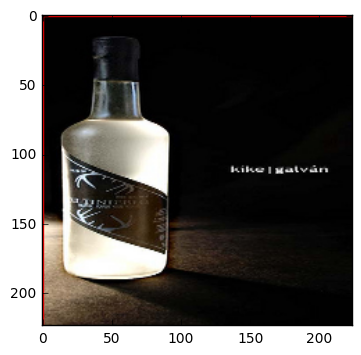

[  0   0 224 224]


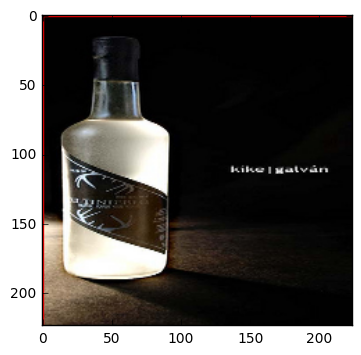

[  0   0 224 224]
boxH:224 boxW:224


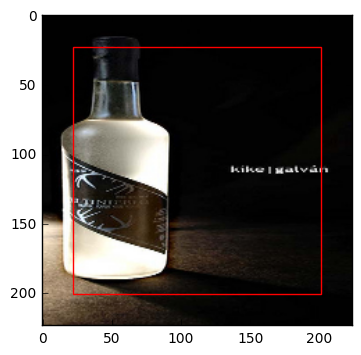

[ 22  22 201 201]


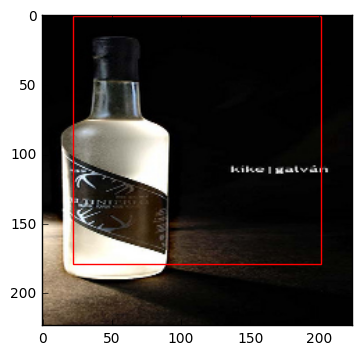

[ 22   0 201 179]


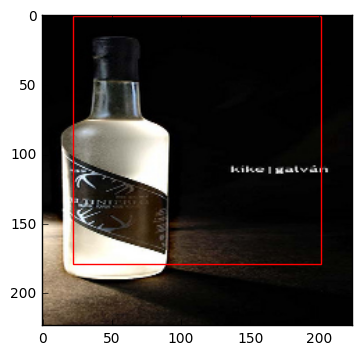

[ 22   0 201 179]


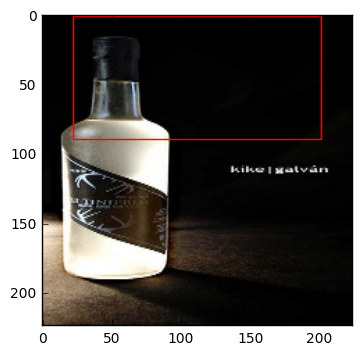

[ 22   0 201  89]


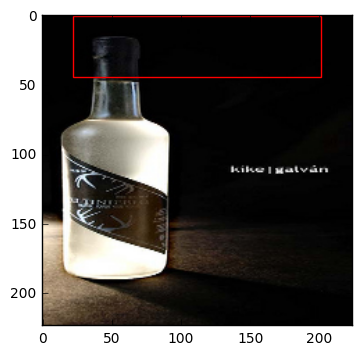

[ 22   0 201  44]


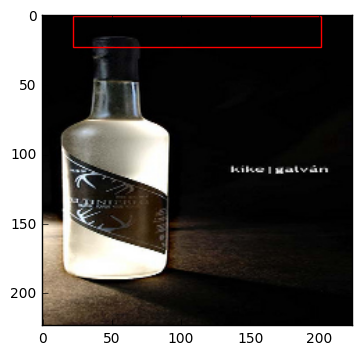

[ 22   0 201  22]


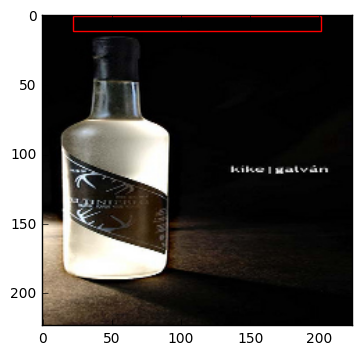

[ 22   0 201  11]


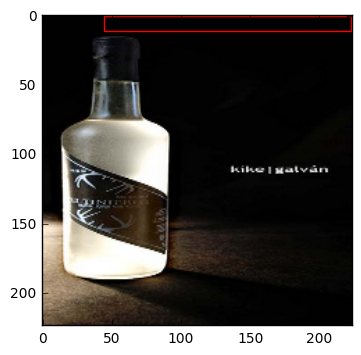

[ 44   0 223  11]


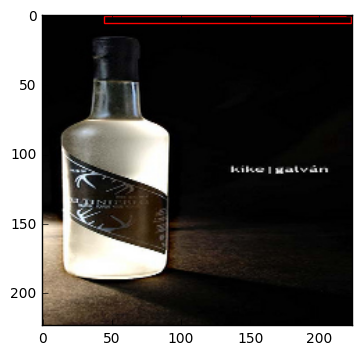

[ 44   0 223   5]


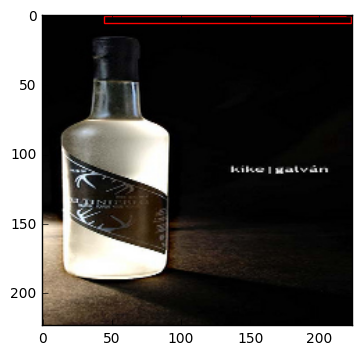

[ 44   0 223   5]


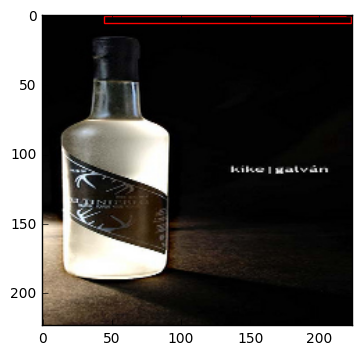

[ 44   0 223   5]


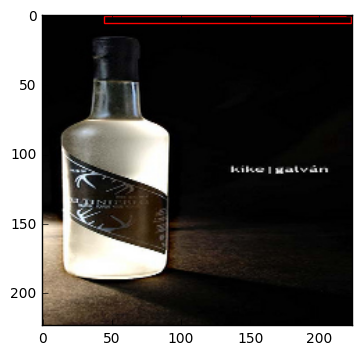

[ 44   0 223   5]


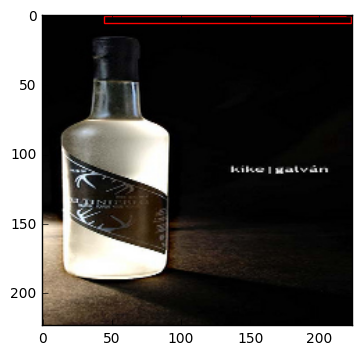

[ 44   0 223   5]


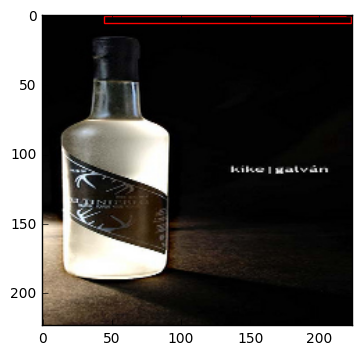

[ 44   0 223   5]


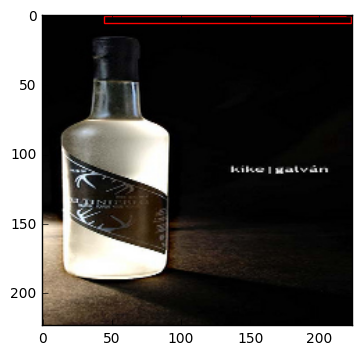

[ 44   0 223   5]
boxH:5 boxW:179
newdelta:1


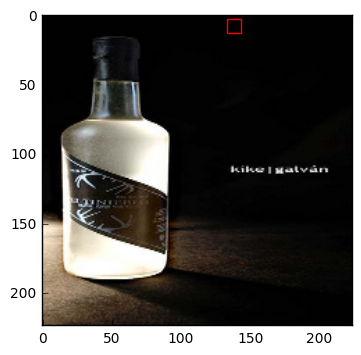

[133   2 143  12]


In [4]:
import random
im2 = (Image.open('../VOC2012/JPEGImages/2009_002749.jpg'))
actions = np.array(random.sample(range(0, 11),9))
agent = ObjLocaliser(np.array(im2),{'xmin':[16], 'xmax':[93], 'ymin':[37], 'ymax':[432]})
#print agent.targets[0]
#agent.agent_window = [0, 0, 105, 224]
#agent.drawActions()
#print agent.takingActions(10)

for act in [5,5,6,5,5,9,9,9,9,0,9,9,9,9,9,9,9,6]:
    #print agent.agent_window
    #agent.drawActions()
    agent.takingActions(act)
    agent.drawActions()
    #print("action:{0}".format(actn[act]))
    #print("width:{0}    Height:{1}".format(agent.agent_window[2] - agent.agent_window[0],agent.agent_window[3] - agent.agent_window[1]))
    #print agent.intersectionOverUnion(agent.agent_window, [170,  58, 220, 206])
    #agent.drawActions()
    #agent.wrapping()
    print agent.agent_window
    #time.sleep(1)
    

(224, 224, 3)


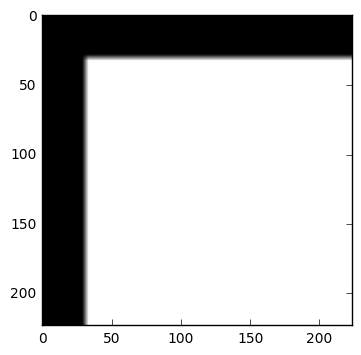

In [46]:
fake_input = np.zeros((224,224,3))
fake_input[87:137,87:137,:] = 1
agent = ObjLocaliser(fake_input, {'xmin':[87], 'ymin':[137],'xmax':[87], 'ymax':[137]})
agent.agent_window = [80,80,130,130]
plt.imshow(agent.wrapping()[:,:,0:3])

#for i in [7,7,7]:
#    print agent.takingActions(i)
#    agent.drawActions()

making animation: https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531

(333, 500, 3)
(333, 500, 3)


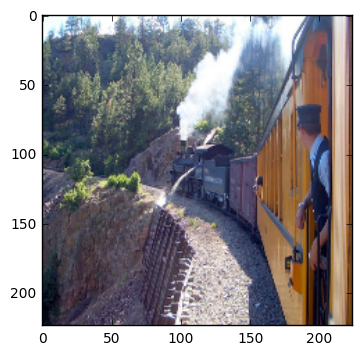

In [34]:
import numpy as np
im2 = np.array(Image.open('../VOC2012/JPEGImages/2010_000959.jpg'))
print im2.shape
a = np.stack((im2[:,:,0],im2[:,:,1],im2[:,:,2]), axis=2)
#plt.imshow(a)

agent = ObjLocaliser(im2,{'xmin':[170], 'xmax':[220], 'ymin':[58], 'ymax':[206]})
agent.takingActions(8)
b= agent.wrapping()
#plt.imshow(b[:,:,0:3])
plt.imshow(b[:,:,3:6])